# Preamble

importing

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

from plot_utils import plot_probabilities


# Neural networks on non-linear data

Some familiar datasets to see how neural networks handle them.

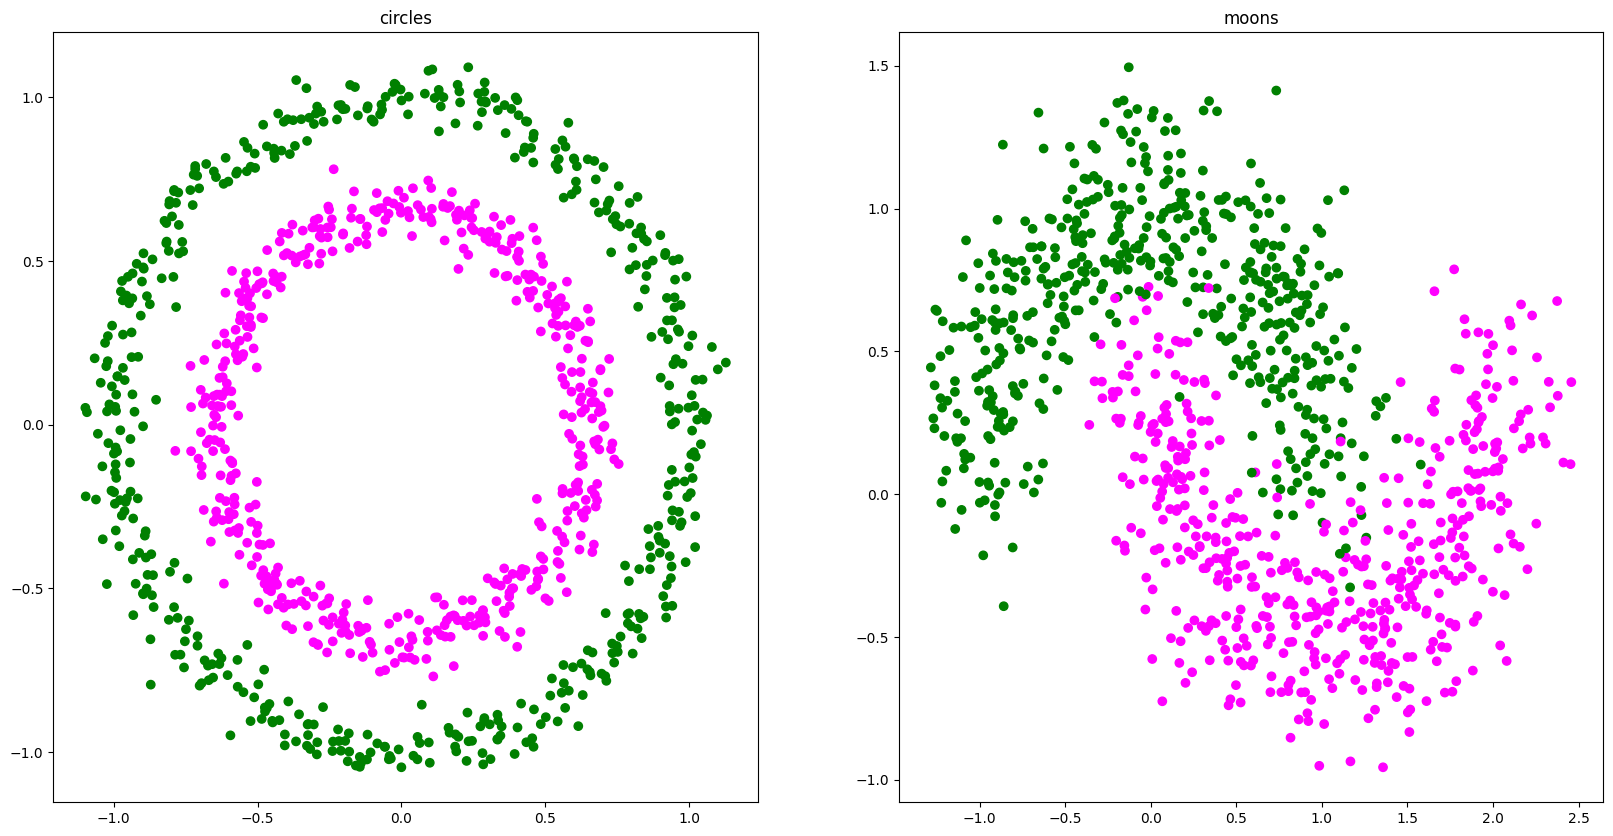

In [2]:
from sklearn.datasets import make_moons, make_circles

colors = ListedColormap(['green', 'magenta', 'yellow', 'blue'])

X_moons, y_moons = make_moons(n_samples=1000, noise = .2, random_state = 504)
X_circles, y_circles = make_circles(n_samples=1000, factor=.65, noise = .05, random_state = 504)

figure = plt.figure(figsize=(20, 10))

ax = figure.add_subplot(1, 2, 2, title='moons')
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=ListedColormap(['green', 'magenta']))

ax = figure.add_subplot(1, 2, 1, title='circles')
ax.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap=ListedColormap(['green', 'magenta']))


### Circles

Circles are the simplest of the two. Let's see if we can use a simple network.

The code below creates one hidden layer and one output layer. The input layer gets created automatically when we give the hidden layer the input_dim attribute.

The output layer is a single node with a sigmoid activation, since this is a binary classifier. Another popular choice for binary classifiers is to make two nodes with a softmax activation. There isn't much difference between the two approaches, but softmax is a real staple of modern neural networks.

We're using the classic sigmoid activation function because it's the easiest to interpret.

Note, the use of the Adam optimizer. Stochastic gradient descent does not converge.

In [33]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(504)
ann1 = tf.keras.Sequential([
  layers.InputLayer(2),
  layers.Dense(4, activation="sigmoid"),
  layers.Dense(1, activation="sigmoid")])

ann1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=.01), metrics=['accuracy'])
ann1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 4)                 12        
                                                                 
 dense_18 (Dense)            (None, 1)                 5         
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


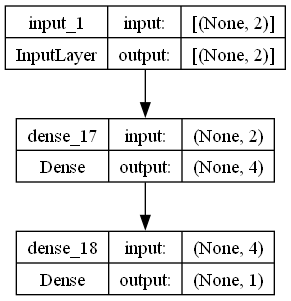

In [34]:
tf.keras.utils.plot_model(ann1, show_shapes=True)

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_circles, y_circles, random_state=504)

ann1.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid))


Epoch 1/200
24/24 [==============================] - 1s 7ms/step - loss: 0.7023 - accuracy: 0.5013 - val_loss: 0.6965 - val_accuracy: 0.4720
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5440 - val_loss: 0.6950 - val_accuracy: 0.4960
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.4427 - val_loss: 0.6975 - val_accuracy: 0.4160
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4947 - val_loss: 0.6957 - val_accuracy: 0.4480
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.4373 - val_loss: 0.6977 - val_accuracy: 0.3320
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.4720 - val_loss: 0.6988 - val_accuracy: 0.4600
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.4587 - val_loss: 0.6956 - val_accuracy: 0.4440
Epoch 8/200
2

If we train this enough, we can get it down to almost perfect.

**Note:** If you call fit() again, it will continue from the already trained weights. This is a way to experiment with the number of epochs run.

1250/1250 [==============================] - 1s 654us/step


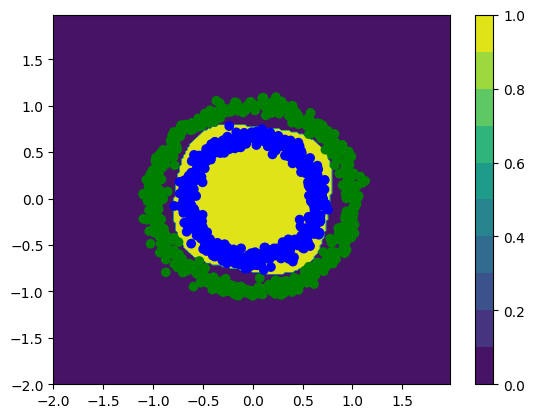

In [36]:
plot_probabilities(ann1, X_circles, y_circles, colors, post_process=np.round)

With a network as simple as this, it's easy to get a feel for how the network works by inspecting the output of the hidden layer.

In [37]:
early_layers = ann1.layers[:-1]

This is an array containing all the layers but the top one. (That is, the hidden layer and the implicit input layer.)

In [38]:
hidden = tf.keras.Sequential(early_layers)

We create a new neural network with the remaining layers. These layers retain their weights and biases, so we can use this to examine how the network works.

It could also be used as a _pre-trained_ network to be used as the basis for another ANN. This is of course more relevant with more complex networks.

1250/1250 [==============================] - 1s 620us/step


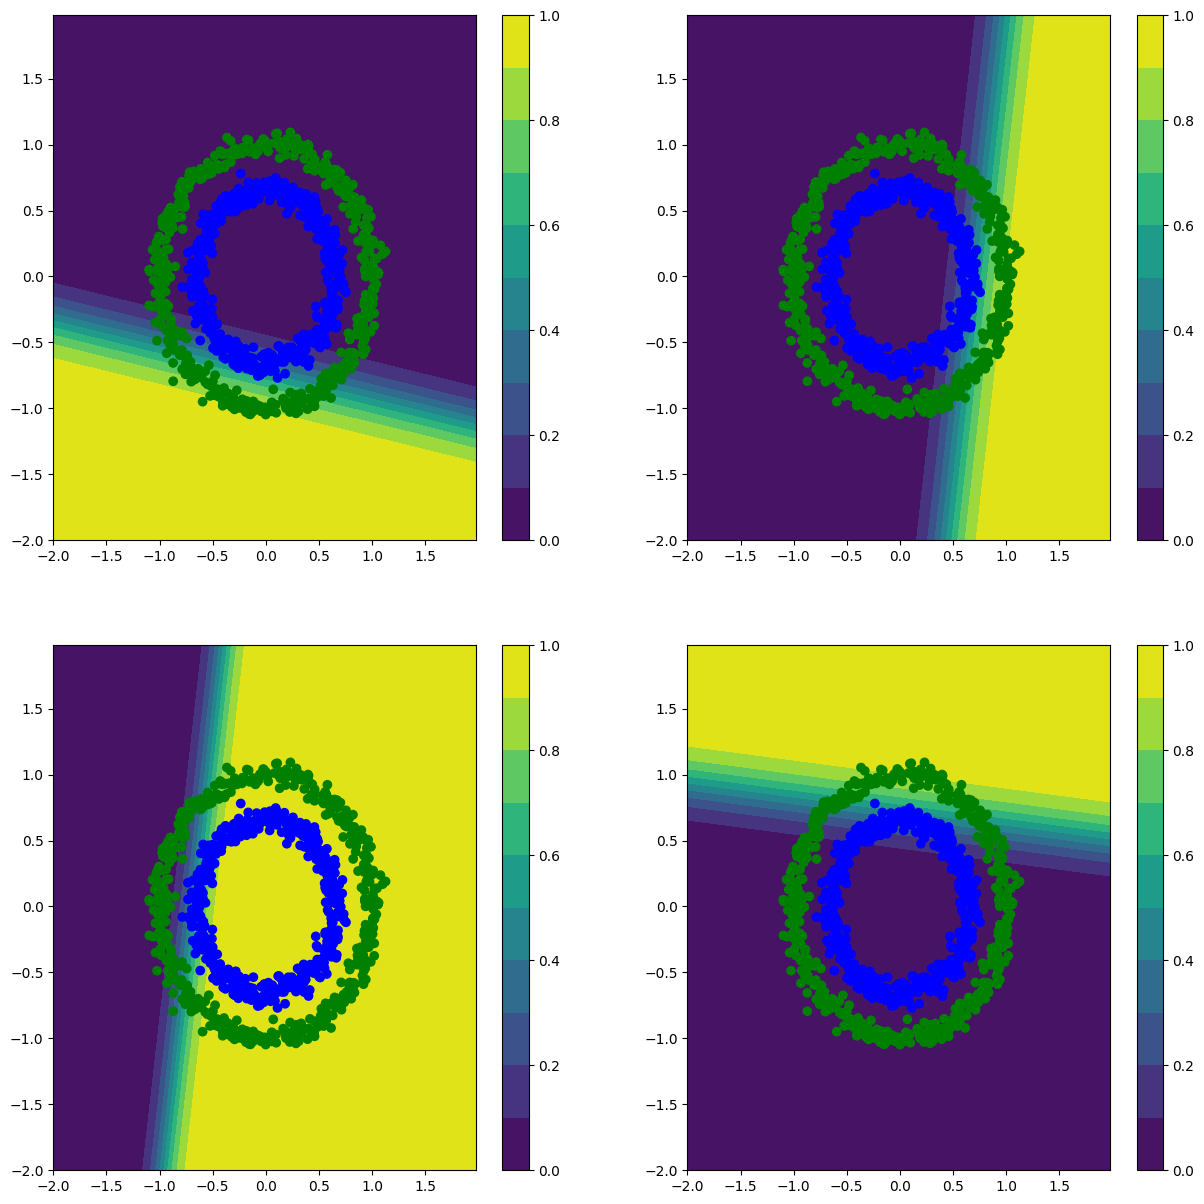

In [39]:

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

plot_probabilities(hidden, X_circles, y_circles, colors, ax=axes[0][0])
plot_probabilities(hidden, X_circles, y_circles, colors, dim=1, ax=axes[0][1])
plot_probabilities(hidden, X_circles, y_circles, colors, dim=2, ax=axes[1][0])
plot_probabilities(hidden, X_circles, y_circles, colors, dim=3, ax=axes[1][1])

### Moons

The moons are more complex, so let's try adding another layer (we could also have tried more neurons in the hidden layer).

In [40]:
tf.random.set_seed(504)
ann2 = tf.keras.Sequential([
  layers.Dense(4, input_dim=2, activation="sigmoid"),
  layers.Dense(4, activation="sigmoid"),
  layers.Dense(1, activation="sigmoid")])

ann2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=.01), metrics=['accuracy'])

200 epochs is a lot for these simple problems. Either they hit a plateau or they converge before that. Instead of fine tuning that each time, let's add a callback.

The *early stopping* callback is called after each epoch and evaluates if the optimizer is making much progress (by default by looking at the validation loss). In the example, the fitting stops if no progress has been made for the last 20 epochs.

In [41]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

It doesn't go well.

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X_moons, y_moons, random_state=504)

history = ann2.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/200
24/24 [==============================] - 1s 8ms/step - loss: 0.6891 - accuracy: 0.6080 - val_loss: 0.6731 - val_accuracy: 0.7080
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.6827 - val_loss: 0.6435 - val_accuracy: 0.8280
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6162 - accuracy: 0.8387 - val_loss: 0.5831 - val_accuracy: 0.8360
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.8373 - val_loss: 0.5083 - val_accuracy: 0.8240
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.8467 - val_loss: 0.4404 - val_accuracy: 0.8400
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4024 - accuracy: 0.8507 - val_loss: 0.3965 - val_accuracy: 0.8400
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8613 - val_loss: 0.3644 - val_accuracy: 0.8520
Epoch 8/200
2

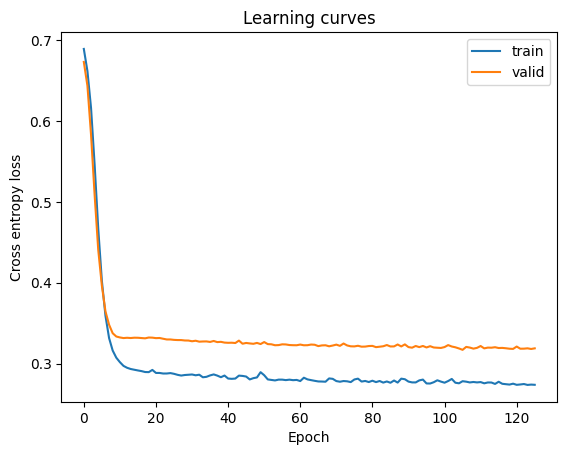

In [43]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

1172/1172 [==============================] - 1s 698us/step


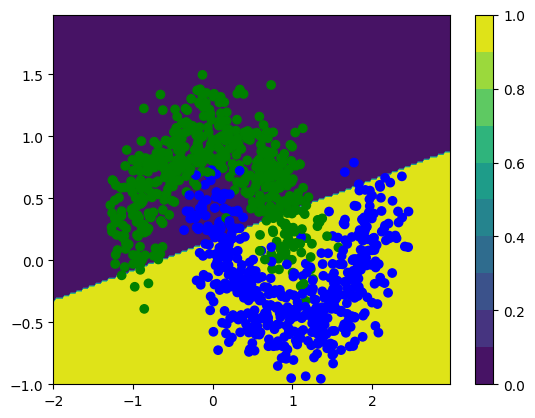

In [44]:
plot_probabilities(ann2, X_moons, y_moons, colors, post_process=np.round)

The sigmoid activation function has a very small window of operations before it causes vanishing gradients. For this reason, it is not used much except when you specifically want a probability.

We'll replace it with ReLU (tanh works, too).

In [45]:
ann2 = tf.keras.Sequential([
  layers.Dense(4, input_dim=2, activation="relu"),
  layers.Dense(4, activation="relu"),
  layers.Dense(1, activation="sigmoid")])

ann2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=.005), metrics=['accuracy'])
history = ann2.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/200
24/24 [==============================] - 1s 7ms/step - loss: 0.7136 - accuracy: 0.5587 - val_loss: 0.6394 - val_accuracy: 0.5640
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5733 - accuracy: 0.7080 - val_loss: 0.5382 - val_accuracy: 0.8480
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.8560 - val_loss: 0.4826 - val_accuracy: 0.8360
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.8573 - val_loss: 0.4533 - val_accuracy: 0.8560
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4134 - accuracy: 0.8667 - val_loss: 0.4279 - val_accuracy: 0.8600
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3903 - accuracy: 0.8733 - val_loss: 0.4078 - val_accuracy: 0.8600
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8787 - val_loss: 0.3878 - val_accuracy: 0.8680
Epoch 8/200
2

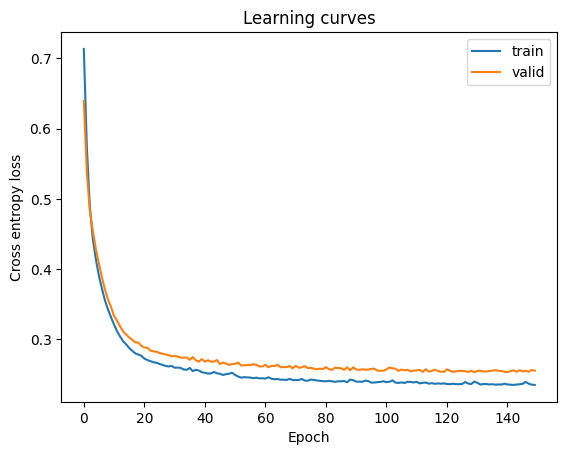

In [46]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

1172/1172 [==============================] - 1s 680us/step


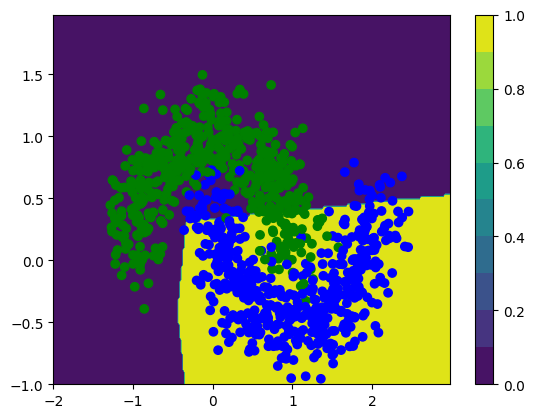

In [47]:
plot_probabilities(ann2, X_moons, y_moons, colors, post_process=np.round)

Alternatively, we can _normalize_ the data between layers. The batch normalization layer scales the data to a (learned) mean and standard deviation. This helps keep the values in the active region. It is commonly used with sigmoid and tanh activation functions.

In [48]:
ann2 = tf.keras.Sequential([
  layers.Dense(4, input_dim=2, activation="sigmoid"),
  layers.BatchNormalization(),
  layers.Dense(4, activation="sigmoid"),
  layers.BatchNormalization(),
  layers.Dense(1, activation="sigmoid")])

ann2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=.002), metrics=['accuracy'])


In [49]:

history=ann2.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/200
24/24 [==============================] - 1s 9ms/step - loss: 0.5575 - accuracy: 0.6533 - val_loss: 0.7547 - val_accuracy: 0.4600
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4581 - accuracy: 0.7973 - val_loss: 0.7442 - val_accuracy: 0.4600
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4048 - accuracy: 0.8440 - val_loss: 0.7402 - val_accuracy: 0.4600
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3669 - accuracy: 0.8440 - val_loss: 0.7302 - val_accuracy: 0.4600
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3444 - accuracy: 0.8640 - val_loss: 0.7205 - val_accuracy: 0.4600
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.8600 - val_loss: 0.7101 - val_accuracy: 0.4600
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3135 - accuracy: 0.8560 - val_loss: 0.6882 - val_accuracy: 0.4600
Epoch 8/200
2

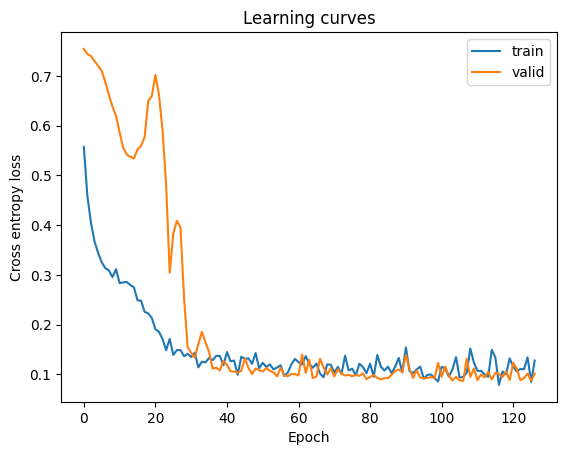

In [50]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

1172/1172 [==============================] - 1s 718us/step


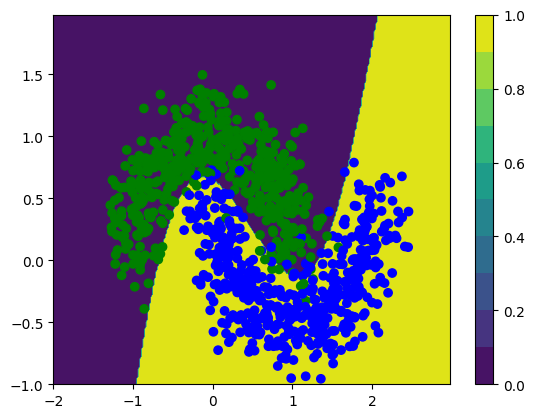

In [51]:
plot_probabilities(ann2, X_moons, y_moons, colors, post_process=np.round)

1172/1172 [==============================] - 1s 634us/step


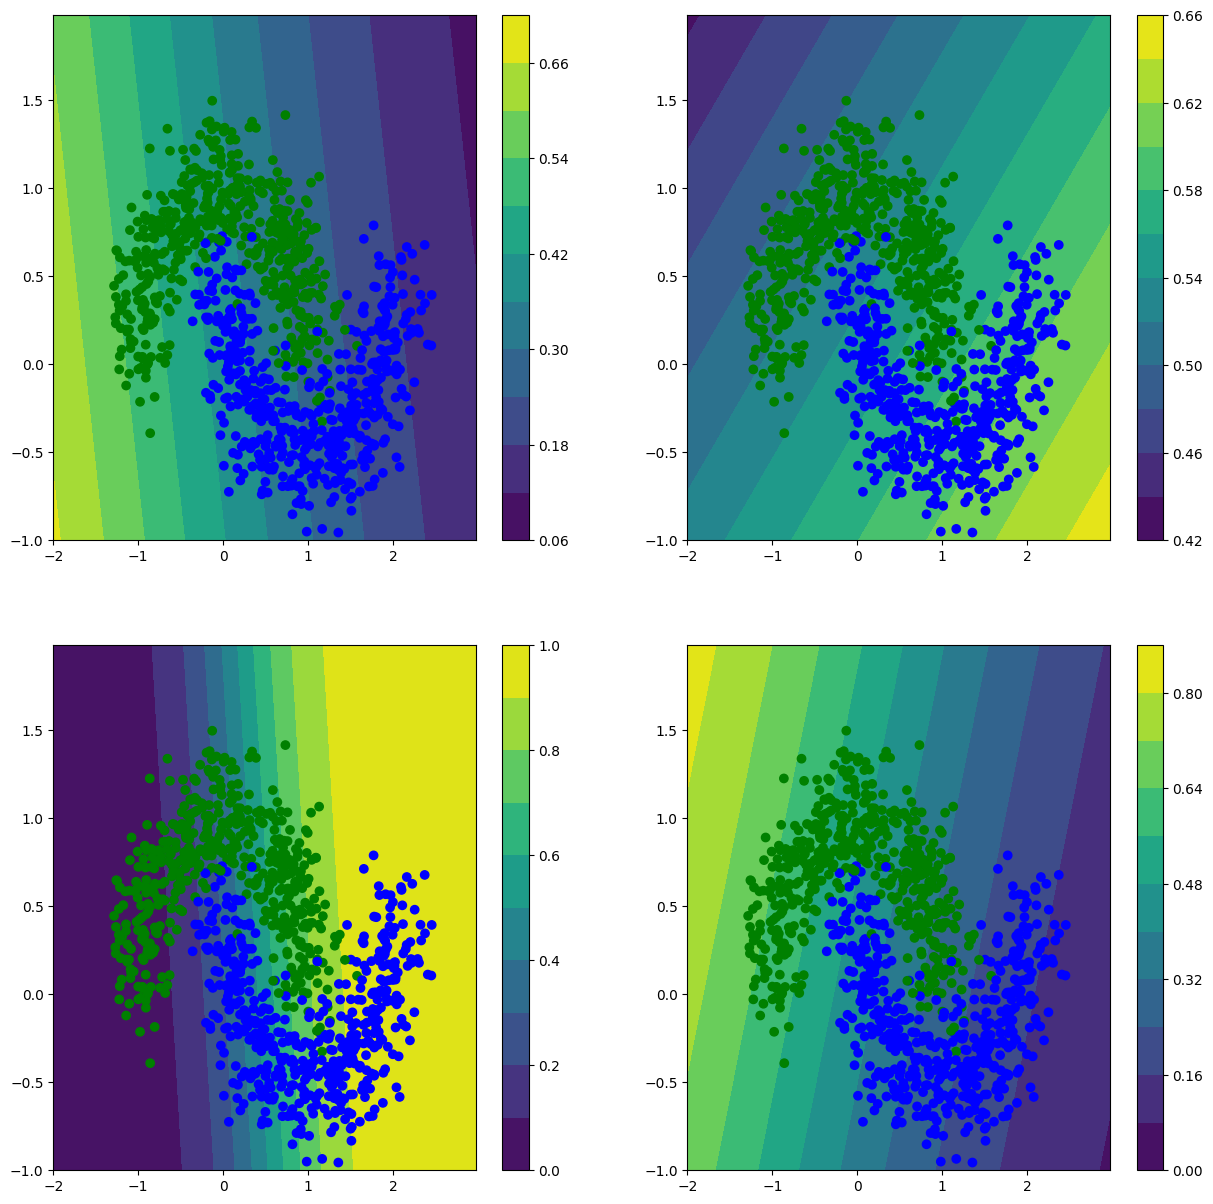

In [52]:
hidden = tf.keras.Sequential(ann2.layers[:-4])

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

plot_probabilities(hidden, X_moons, y_moons, colors, ax=axes[0][0])
plot_probabilities(hidden, X_moons, y_moons, colors, dim=1, ax=axes[0][1])
plot_probabilities(hidden, X_moons, y_moons, colors, dim=2, ax=axes[1][0])
plot_probabilities(hidden, X_moons, y_moons, colors, dim=3, ax=axes[1][1])

1172/1172 [==============================] - 1s 706us/step


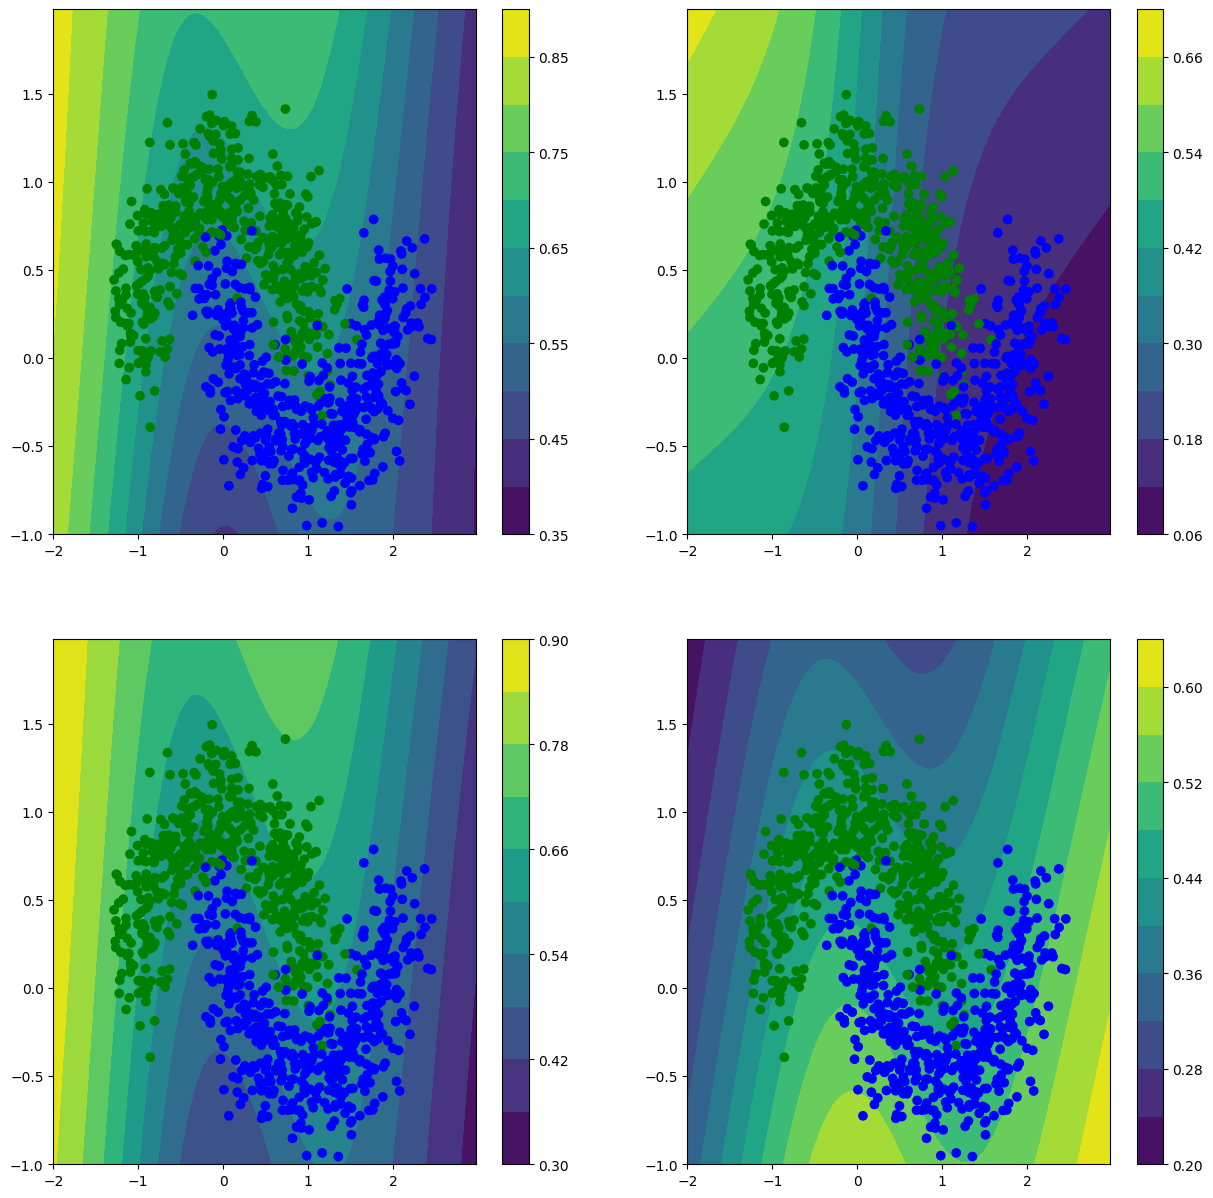

In [53]:
hidden = tf.keras.Sequential(ann2.layers[:-2])

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

plot_probabilities(hidden, X_moons, y_moons, colors, ax=axes[0][0])
plot_probabilities(hidden, X_moons, y_moons, colors, dim=1, ax=axes[0][1])
plot_probabilities(hidden, X_moons, y_moons, colors, dim=2, ax=axes[1][0])
plot_probabilities(hidden, X_moons, y_moons, colors, dim=3, ax=axes[1][1])